In [1]:
import numpy as np
import pandas as pd

INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/BLA_LFP_data/Part2SubjectHB15_AW.mat'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_background.mat'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_bg_like_sig.mat'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine_syn_noise.mat'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine.txt'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/SyntheticNoiseData/LFP_elec_combine_syn_noise.mat'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/FR_PN_ITN.txt'

In [2]:
from scipy import signal, io, fft, stats
from lfp_prediction.config import params
from tqdm.notebook import tqdm
import re
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')


def get_invivo():

    mat = io.loadmat(INVIVO_RAW_PATH)['LFP_seg']
    df_list = []

    for i, arr in enumerate(mat):
        if i == 0:
            vals = arr[0]
            continue
        np.append(vals, arr[0])

    for arr in tqdm(mat):
        if arr[0].shape[0] == 1:
            arr[0] = np.transpose(arr[0], axes=(1,0))
        # print(arr[0].shape)
        if arr[0].shape[0] < (params.PREVIOUS_TIME + params.LOOK_AHEAD):
            continue
        df_list.append(pd.DataFrame(arr[0]))
    return df_list

def get_feng(column: int = None):
    with open(INVIVO_RAW_PATH, 'r') as f:
        data = f.readlines()

    if column:
        data = [re.findall(r'\d+', d)[column-1] for d in data]
        data = np.array(list(map(float, data))).reshape((-1, 1))
    else:
        data = np.array(list(map(float, data))).reshape((-1, 1))

    global_std = np.std(data)
    global_mean = np.mean(data)
    df_list = [pd.DataFrame(((data - global_mean) / global_std))]
    return df_list

# df_list = get_feng(column=None)
df_list = get_invivo()
df_list[0].drop(labels=df_list[0].index[300:],
                axis=0,
                inplace=True)
print(len(df_list[0].index))
df_list[0].head()
print(len(df_list))

  0%|          | 0/51 [00:00<?, ?it/s]

300
51


In [4]:
# large_df = pd.concat(df_list, axis=1)
# large_df.columns = [str(i) for i in range(len(df_list))]
# large_df

large_df = df_list[8].iloc[:1000]
large_df

,0
0,-89
1,-6
2,-26
3,33
4,9
...,...
995,-221
996,-228
997,-260
998,-282


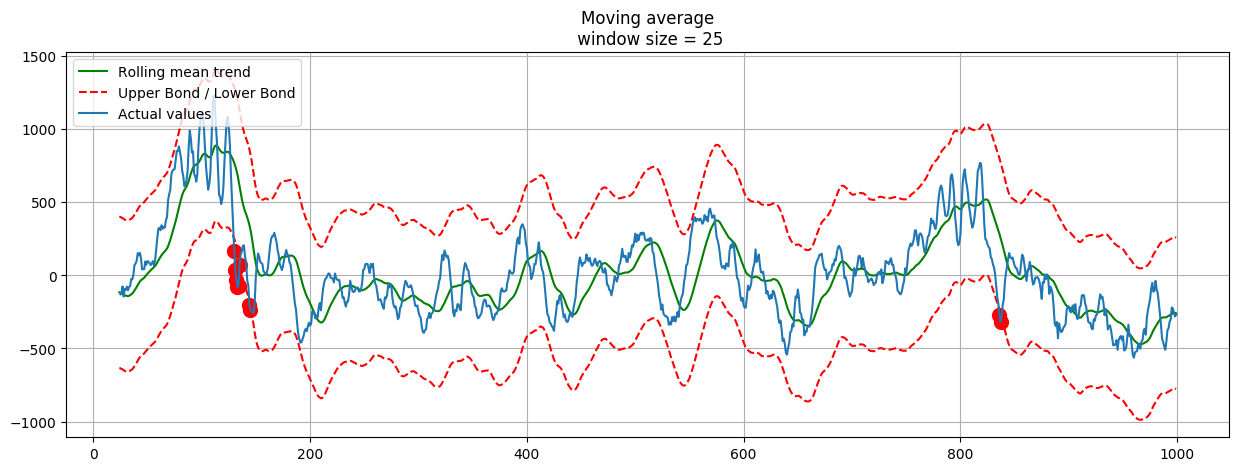

In [5]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import matplotlib.pyplot as plt

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

plotMovingAverage(large_df, 25, plot_intervals=True, plot_anomalies=True)
plt.show()

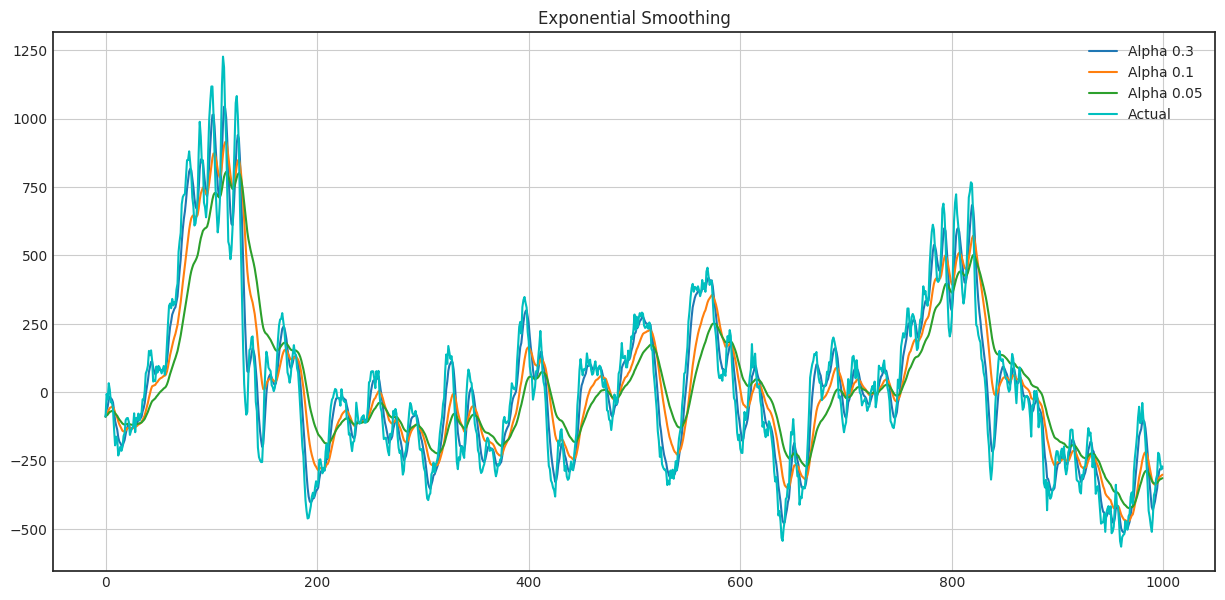

In [6]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

plotExponentialSmoothing(large_df.iloc[:,0], [0.3, 0.1, 0.05])
plt.show()

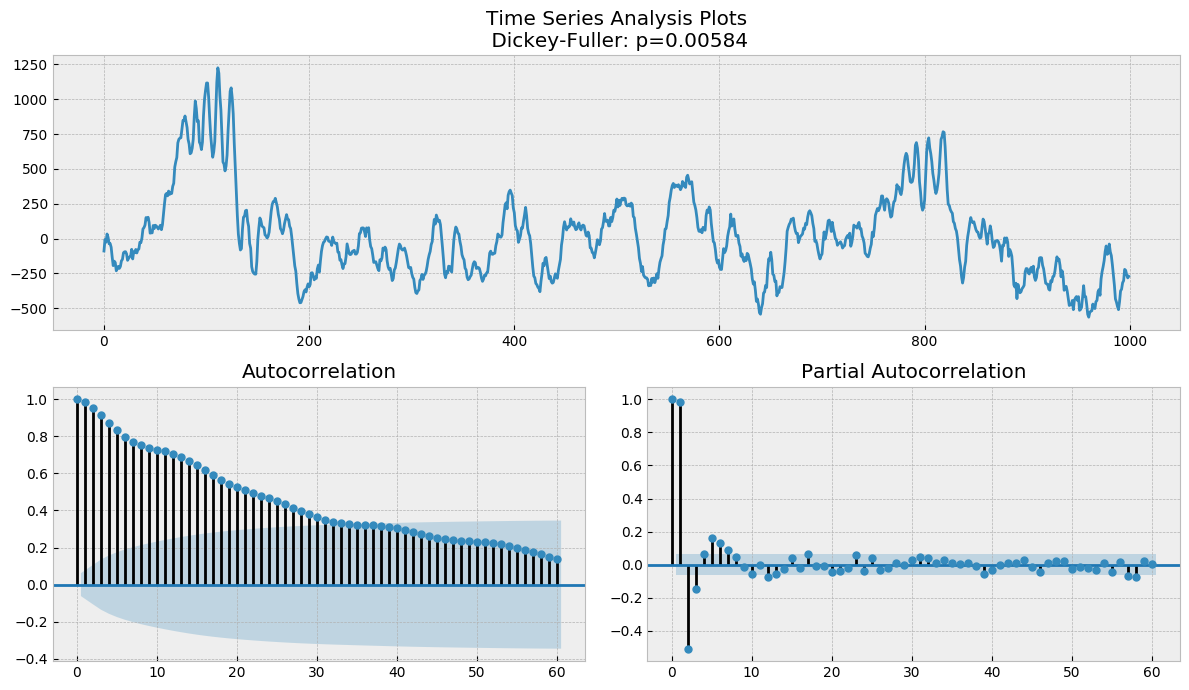

In [7]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(large_df.iloc[:,0], lags=60)
plt.show()

In [8]:
from itertools import product

# setting initial values and some bounds for them
ps = range(5, 7)
d=1
qs = range(10, 12)
Ps = range(5, 7)
D=0
Qs = range(2, 4)
s = 20 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [ ]:
from tqdm import tqdm_notebook

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(large_df.iloc[:,0], order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

result_table = optimizeSARIMA(parameters_list, d, D, s)

p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(large_df.iloc[:,0], order=(p, d, q),
                                     seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
tsplot(best_model.resid[20+1:], lags=60)
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

plotSARIMA(large_df, best_model, 100)

data_df = get_invivo()
# data_df = get_feng(column=None)
plt.plot(np.arange(1000, 1100), data_df[8].iloc[1000:1100, :].values)
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                             cv=tscv,
                             scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())

        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

def prepareData(series, lag_start, lag_end, test_size):
    """
        series: pd.DataFrame
            dataframe with timeseries
        lag_start: int
            initial step back in time to slice target variable
            example - lag_start = 1 means that the model
                      will see yesterday's values to predict today
        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model
                      will see up to 4 days back in time to predict today
        test_size: float
            size of the test dataset after train/test split as percentage of dataset
        target_encoding: boolean
            if True - add target averages to the dataset

    """

    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]

    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test =\
        timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test =\
    prepareData(large_df.iloc[:,0], lag_start=6, lag_end=25, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

plotModelResults(xgb,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True, plot_anomalies=True)
plt.show()